In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, LearningCurveDisplay, learning_curve, ValidationCurveDisplay, validation_curve
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    fbeta_score,
    classification_report,
    make_scorer
)


from utils import get_data, get_df_details, plot_distrb, make_confusion_matrix

# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
X, y, metadata, variables = get_data('census_income')

In [6]:
# Remove nulls

# Replace ? with np.nan
X.replace({'workclass': {'?': np.nan},
           'occupation': {'?': np.nan},
           'native-country': {'?': np.nan}}, 
           inplace=True)

r, _ = np.where(pd.isnull(X))

idx = [i for i in range(X.shape[0]) if i not in r]
X = X.iloc[idx, :]
y = y.iloc[idx, :]

In [7]:
# Filter to USA and remove columns capital-loss, capital-gain
r = np.where(X['native-country']=='United-States')
X = X.iloc[r[0], :].copy()
y = y.iloc[r[0], :].copy()

excl_col = ['native-country', 'capital-loss', 'capital-gain']
X.drop(columns=excl_col, inplace=True)

In [8]:
# update the metadata
variables = variables.query('name not in @excl_col')

In [9]:
# This is an imbalanced dataset 
# https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

y.replace({'<=50K.': '<=50K', '>50K.': '>50K'}, inplace=True)
y.value_counts(normalize=True)

income
<=50K     0.746973
>50K      0.253027
Name: proportion, dtype: float64

In [10]:
# Split data into train and test sets.
# We use Stratifield sampling to ensure that the distribution of the data is maintained across the sample.
# Use stratified kfold cross validation to ensure that the model is not overfitting the data

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [11]:
idx = variables['type'].isin(['Integer', 'Continuous'])
num_cols = variables.loc[idx, 'name']
num_cols = num_cols.loc[~num_cols.isin(y.columns.tolist())]
num_cols

0                age
2             fnlwgt
4      education-num
12    hours-per-week
Name: name, dtype: object

In [12]:
idx = variables['type'] == 'Binary'
cat_cols = variables.loc[idx, 'name']
cat_cols = cat_cols.loc[~cat_cols.isin(y.columns)]
cat_cols

9    sex
Name: name, dtype: object

# Train DecisionTreeClassifier

In [13]:
# Need to do one hot encoding for the categorical data
# https://www.freecodecamp.org/news/machine-learning-pipeline/

RANDOM_STATE = 42
N_FOLDS = 5
N_JOBS = -1
SCORING = 'accuracy'
VERBOSE = 4


# Use minmax scaler for simplicity, scalability, avoids assumption of distribution and there are no outliers in data
num_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])
cat_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse=False))
])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
    ],
    remainder='drop',
    n_jobs=N_JOBS)

clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clf)
])



## Tune the DecisionTreeClassifier

In [16]:
#    Use Gini, Entropy gainn
#    Pruning

cv_scores = []

grid_params = {
        'max_depth': {'model__max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]},
        'min_samples_split': {'model__min_samples_split': [2, 10, 20, 30, 40, 50, 60, 70, 100, 150, 200]},
        'min_samples_leaf': {'model__min_samples_leaf': [1, 5, 10, 50, 100, 150]}
    }

for key, grid_param in grid_params.items():
    print('------------------', key, '------------------')
    
    gs = GridSearchCV(clf_pipeline, grid_param, 
                      cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=VERBOSE, return_train_score=True)
    gs.fit(X_train, y_train)

    cv_scores.append(pd.DataFrame({'param': [key]*len(gs.cv_results_['mean_test_score']),
                                   'value': gs.cv_results_[f'param_{list(grid_param.keys())[0]}'],
                                   'mean_score': gs.cv_results_['mean_test_score']}))

cv_scores = pd.concat(cv_scores)

------------------ max_depth ------------------
Fitting 5 folds for each of 10 candidates, totalling 50 fits
------------------ min_samples_split ------------------
Fitting 5 folds for each of 11 candidates, totalling 55 fits
------------------ min_samples_leaf ------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


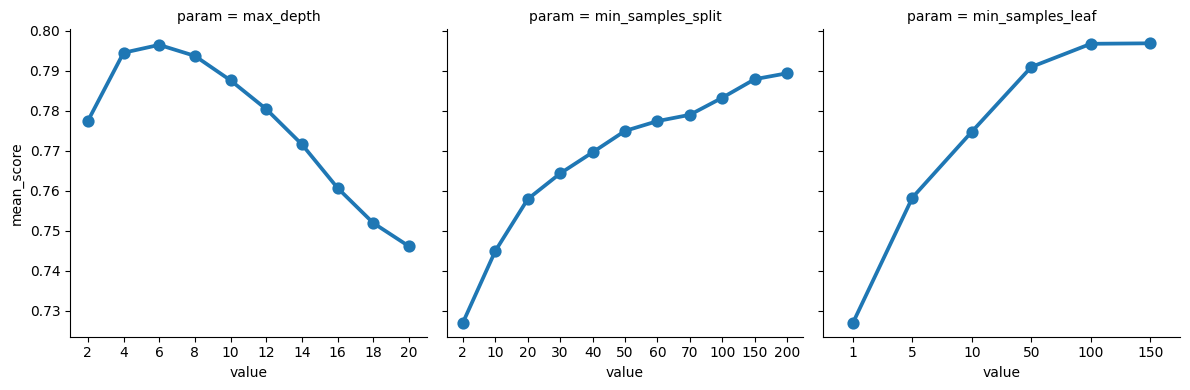

In [17]:

sns.FacetGrid(cv_scores, col='param', col_wrap=3, height=4, sharex=False).map(sns.pointplot, 'value', 'mean_score')

In [18]:
cv_scores = []

grid_params = {
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [2, 4, 6, 8, 10],
        'model__min_samples_split': [2, 10, 20, 30, 40, 50, 60, 70, 100, 150, 200],
        'model__min_samples_leaf': [1, 5, 10, 50, 100, 150]
    }

    
gs = GridSearchCV(clf_pipeline, grid_params, 
                    cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=VERBOSE, return_train_score=True)
gs.fit(X_train, y_train)

print("Best Score of train set: "+str(gs.best_score_))
print("Best parameter set: "+str(gs.best_params_))
print("Test Score: "+str(gs.score(X_test,y_test)))

Fitting 5 folds for each of 660 candidates, totalling 3300 fits
Best Score of train set: 0.7982926529404565
Best parameter set: {'model__criterion': 'gini', 'model__max_depth': 8, 'model__min_samples_leaf': 100, 'model__min_samples_split': 2}
Test Score: 0.8008233442305364


In [19]:
gs.best_estimator_['model']

DecisionTreeClassifier(max_depth=8, min_samples_leaf=100, random_state=42)

In [20]:
import joblib
joblib.dump(value=gs, filename='./model/dt_census_income_ppl.pkl', compress=True)
joblib.dump(value=gs.best_estimator_, filename='./model/dt_census_income_best.pkl', compress=True)

['dt_census_income_best.pkl']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  55 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  28 out of  55 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  42 out of  55 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    1.4s finished


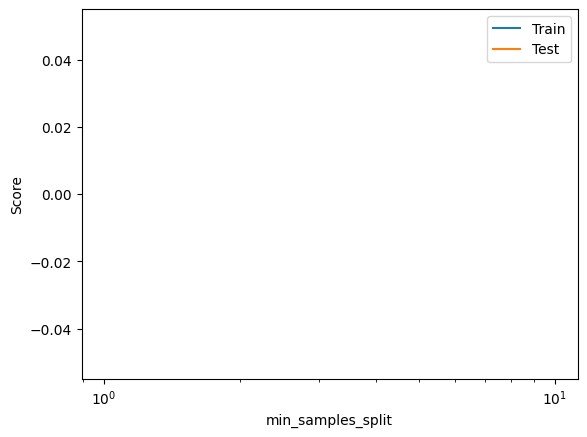

In [21]:
from sklearn.model_selection import ValidationCurveDisplay, validation_curve


param_name, param_range = "min_samples_split", np.array([2, 10, 20, 30, 40, 50, 60, 70, 100, 150, 200])
train_scores, test_scores = validation_curve(
     gs.best_estimator_['model'], X, y, param_name=param_name, param_range=param_range, cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=VERBOSE
 )
display = ValidationCurveDisplay(
     param_name=param_name, param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="Score"
)
display.plot()
plt.show()

In [22]:
gs.cv_results_.keys()

# gs.cv_results_['mean_test_score']

# dict_keys(['mean_fit_time', 'std_fit_time', 
# 'mean_score_time', 'std_score_time', 
# 'param_model__max_depth', 'params', 
# 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 
# 'mean_test_score', 'std_test_score', 'rank_test_score', 
# 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 
# 'mean_train_score', 'std_train_score'])


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_model__criterion', 'param_model__max_depth', 'param_model__min_samples_leaf', 'param_model__min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [23]:

# Plot learning curve of the best model from grid search
train_size_abs, train_scores, test_scores = \
    learning_curve(gs.best_estimator_, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=N_FOLDS, n_jobs=N_JOBS, scoring=SCORING, verbose=VERBOSE)

[learning_curve] Training set sizes: [ 2642  5285  7927 10570 13213 15855 18498 21140 23783 26426]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  50 | elapsed:    0.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed:    1.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.0s finished


<Axes: xlabel='train_size_abs', ylabel='value'>

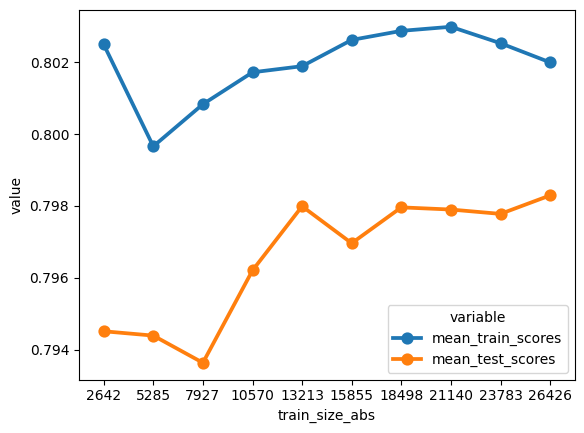

In [24]:
plot_df = pd.DataFrame({'train_size_abs': train_size_abs, 
                        'mean_train_scores': np.mean(train_scores, axis=1), 
                        'mean_test_scores': np.mean(test_scores, axis=1)})
plot_df = plot_df.melt(id_vars='train_size_abs', value_vars=['mean_train_scores', 'mean_test_scores'])
sns.pointplot(plot_df, x='train_size_abs',y ='value', hue='variable')

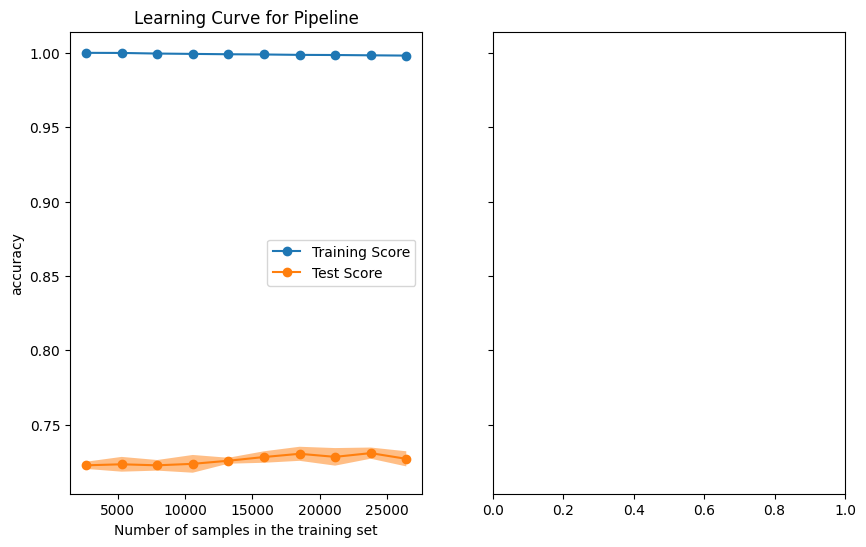

In [25]:

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": N_FOLDS,
    "score_type": "both",
    "n_jobs": N_JOBS,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": SCORING,
}

for ax_idx, estimator in enumerate([clf_pipeline]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

In [26]:
y_test.value_counts()

income
<=50K     6169
>50K      2090
Name: count, dtype: int64

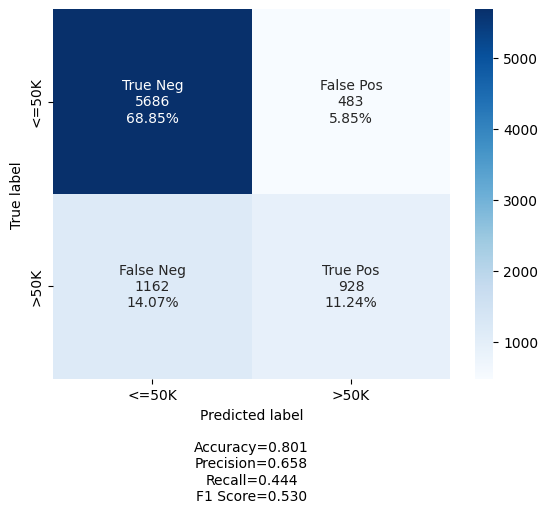

In [27]:
# Get the score of the best model on test

# gs.best_estimator_ is the best model found by GridSearchCV
y_test_predictions = gs.predict(X_test)
# Generate confusion matrix for the predictions from the best model
conf_matrix = confusion_matrix(y_test, y_test_predictions)

make_confusion_matrix(conf_matrix, group_names=['True Neg','False Pos','False Neg','True Pos'], categories=['<=50K', '>50K'], cmap='Blues')

In [28]:

scores = {'accuracy_score':accuracy_score(y_test, y_test_predictions),
          'precision_score':precision_score(y_test, y_test_predictions, pos_label='>50K'),
          'recall_score':recall_score(y_test, y_test_predictions, pos_label='>50K'),
          'f2_score':fbeta_score(y_test, y_test_predictions, beta=2, pos_label='>50K')
}

print(scores)


{'accuracy_score': 0.8008233442305364, 'precision_score': 0.6576895818568391, 'recall_score': 0.44401913875598087, 'f2_score': 0.47487462900419614}


In [29]:

# target_names=target_names
print(classification_report(y_test, y_test_predictions))


              precision    recall  f1-score   support

       <=50K       0.83      0.92      0.87      6169
        >50K       0.66      0.44      0.53      2090

    accuracy                           0.80      8259
   macro avg       0.74      0.68      0.70      8259
weighted avg       0.79      0.80      0.79      8259



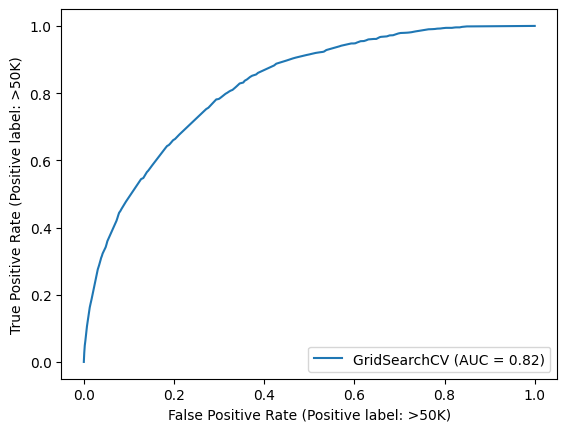

In [30]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(gs, X_test, y_test, )
plt.show()

In [32]:
# plot precison recall curve
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_recall_curve,
                              PrecisionRecallDisplay)

precision, recall, _ = precision_recall_curve(y_test, y_test_predictions, pos_label='>50K')
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

TypeError: unsupported operand type(s) for -: 'str' and 'str'